In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import time

from renewable_data_load import *

# Configure dask for parallel execution
import dask
dask.config.set(scheduler='threads', num_workers=2)  # Adjust num_workers to your CPU cores

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Load Data

In [2]:
resource = "windpower"
module = "offshore"
domain = "d03"
variable = "cf"
frequency = "day"
reference_gwl = 0.8

window_size = 60

#for simulation in ["mpi-esm1-2-hr","miroc6","taiesm1"]:
for simulation in ["mpi-esm1-2-hr","miroc6","taiesm1"]:
    start_time = time.time()
    print(f"Processing simulation: {simulation}")
    ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)

    #### SUBSET FOR TESTING ####
    #ren_ds = ren_ds.isel(y=slice(222,226), x=slice(53,57)) # Small slice for testing
    #ren_ds = ren_ds.isel(y=slice(126,226), x=slice(1,57)) # Small slice for testing

    #ren_ds = ren_ds.isel(y=297, x=88)

    # Get bounds for reference GWL period
    WRF_sim_name = sim_name_dict[simulation]
    model = WRF_sim_name.split("_")[1]
    ensemble_member = WRF_sim_name.split("_")[2]
    start_year, end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)

    # Extract reference periods
    ds_reference = ren_ds.sel(time=slice(f"{start_year}", f"{end_year}"))

    ds_window = ds_reference.rolling(time=window_size, center=True).construct("window")
    ds_window = ds_window.assign_coords({"window" : [w for w in np.arange(1,window_size+1,1)]})
    ds_window['dayofyear'] = ds_window.time.dt.dayofyear
    ds_window['year'] = ds_window.time.dt.year
    ds_window = ds_window.assign_coords(
        {"dayofyear":ds_window.time.dt.dayofyear,
        "year":ds_window.time.dt.year}
    )
    # reshape time dimension
    ds_window = ds_window.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

    # flatten each day of year to a 1d vector with all samples (30 day window x number of years)
    ds_window = ds_window.stack(sample=["window","year"])
    ds_window = ds_window.rename("reference_gen")


    # Compute 90th percentile across samples for each day-of-year
    percentile_10 = ds_window.quantile(0.1, dim='sample')

    percentile_10 = percentile_10.load()

    output_path = f"../data/thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
    percentile_10.to_netcdf(output_path)
    print(f"Saved 10th percentile data to: {output_path}")
    end_time = time.time()
    duration_mins = (end_time - start_time) / 60
    print(f"Completed processing for {simulation} in {duration_mins:.2f} minutes.\n")

    # Close datasets to free up memory
    ren_ds.close()
    ds_reference.close()
    ds_window.close()
    percentile_10.close()

Processing simulation: mpi-esm1-2-hr


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_mpi-esm1-2-hr_gwlref0.8_10th_pctile.nc
Completed processing for mpi-esm1-2-hr in 14.95 minutes.

Processing simulation: miroc6


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_miroc6_gwlref0.8_10th_pctile.nc
Completed processing for miroc6 in 69.23 minutes.

Processing simulation: taiesm1


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_taiesm1_gwlref0.8_10th_pctile.nc
Completed processing for taiesm1 in 44.13 minutes.



In [1]:
percentile_10.isel(dayofyear=180).plot()

NameError: name 'percentile_10' is not defined

## Validation: Test at Single Location

In [15]:
test_ds = drought_ds.isel(y=0, x=0)

In [16]:
test_ds = drought_ds

## Visualization: Full Time Series at Test Location

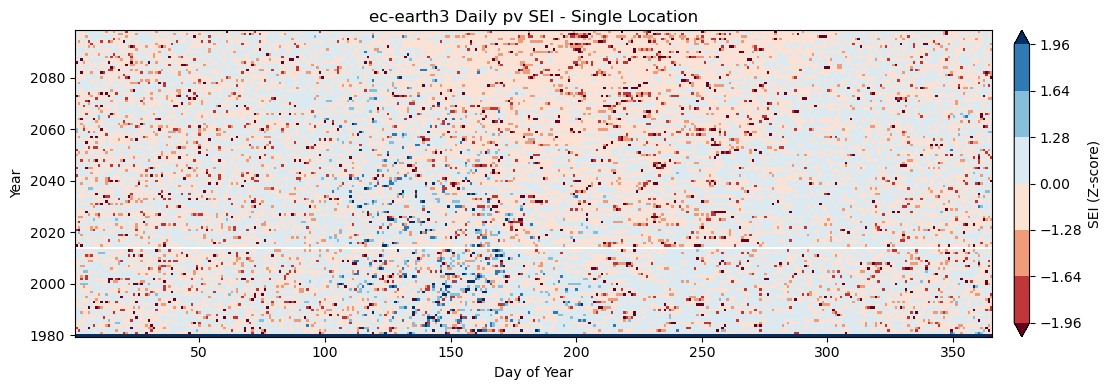

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
xr.plot.imshow(
    test_ds.sei.T, 
    ax=ax, 
    levels=[-1.96, -1.64, -1.28, 0, 1.28, 1.64, 1.96], 
    cmap="RdBu", 
    cbar_kwargs={'pad': 0.02, 'label': 'SEI (Z-score)'}
)
plt.title(f"{simulation} Daily {resource} SEI - Single Location")
plt.ylabel("Year")
plt.xlabel("Day of Year")
plt.tight_layout()
plt.show()